# Effect of Advertising Spend on Product Sales
### *Marketing Mix Modeling (MMM)*

## Author - Lukas FIorio
---

## Intro

In this project we use data on advertising spend to attribute product sales across marketing channels.

Our dataset consists of ad spend and sales in 200 market areas, over a given marketing campaign (for a single product). Our goal is to attribute ad spend to product sales and make a recommendation for future campaigns.

We use multi-linear regression to split product sales into base and incremental sales, attributing incremental sales to each ads channel.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error

## Read data

Our first step is to load the ad spend & sales data for analysis. 

The data is originally sourced from Kaggle [(available here)](https://www.kaggle.com/purbar/advertising-data/download), although in this project we source directly through University of Washington.

In [2]:
# read data into df
file = 'https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Advertising.csv'
ads = pd.read_csv(file, index_col=0)

#### Scale the data

We note from documentation that product sales are stored in \\$K, while ad spend is simply in \\$.  We scale `sales` to match our units.

In [3]:
ads['sales'] = ads['sales'] * 1000
ads.head() # preview data

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22100.0
2,44.5,39.3,45.1,10400.0
3,17.2,45.9,69.3,9300.0
4,151.5,41.3,58.5,18500.0
5,180.8,10.8,58.4,12900.0


## Fit model

Now we fit a multi-linear regression model on sales, based on each ad spend through each channel.

We'll also make predictions and quantify our error (the accuracy of our model).

In [4]:
# initialize & fit model
ols_model = smf.ols(formula = 'sales ~ TV + radio + newspaper', data = ads)
ols_model = ols_model.fit()

# make predictions
sales_pred = ols_model.predict(ads[['TV', 'radio', 'newspaper']])

# calculate error (RMSE and normalized RMSE)
rmse = mean_squared_error(ads['sales'], sales_pred, squared = False)
nrmse = rmse / ads['sales'].mean()

## Evaluate model

### Attribution

Before we examine the model summary, let's look at the slopes associated with each ad spend channel.  These slopes are called the *Partial Regression Coefficients* and they inform our sales attribution and marketing ROI.

We'll need to do a bit more model inspection to validate our findings, but (taking as is) we take the following interpretation:

- Base sales of \\$2,940 -- this is what we would expect in a given region without *any* advertising at all.  This is built on our brand strength.
- Incremental product sales of:
  - \\$45 for every dollar of ad spend on TV ads
  - \\$190 for every dollar of ad spend on radio ads
  - -\\$1 for every dollar of ad spend on newspaper ads

In [5]:
# partial regression coefficients
print('Sales vs Ad Spend')
print('-----------------------')
print(round(ols_model.params, 2).to_string())

Sales vs Ad Spend
-----------------------
Intercept    2938.89
TV             45.76
radio         188.53
newspaper      -1.04


### Model Summary

Now let's take a look at our model summary and error rate.  We're looking to verify the accuracy of our model and the statistical significance of our coefficients (for base sales and ad spend channels).

<ins>*RMSE*</ins><br>
We achieved an RMSE of \\$1,670, which is to say that our model is typically accurate within \\$1,670 of product sales for each region.  Given average sales of \~\\$14,000 per region, the model is typically off by \~12\% of the mean, which is reasonably accurate.

<ins>*R$^2$*</ins><br>
We also see this reflect in the adjusted R$^2$ of 0.896.  This tells us that 89.6\% of the variation in product sales is explained by our model (our base sales and ad spend).

<ins>*Significance*</ins><br>
Looking at the significance of our coefficients, we see our intercept (base sales), TV ad spend, and radio ad spend are all highly significant (p < 0.01).

Newspaper ad spend, however, is not (p = 0.86). The estimated effect of newspaper ad spend was quite small and the 95\% confidence interval around effect size includes \\$0 (no effect).

<ins>*Interpretation*</ins><br>
Given the model accuracy, R$^2$, and coefficient significance, we feel confident in our model results.  The only change we make to our earlier interpretation (in the cell above) is to assume no effect (\$0) from newspaper ad spend.

In [6]:
# error
print('Mean Sales by region:', "${:,.0f}".format(ads['sales'].mean()))
print('                RMSE:', "${:,.0f}".format(rmse))
print('     Normalized RMSE:', "{:,.1%}".format(nrmse))

# show model summary
print('\n', ols_model.summary())

Mean Sales by region: $14,022
                RMSE: $1,669
     Normalized RMSE: 11.9%

                             OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Thu, 14 Jan 2021   Prob (F-statistic):           1.58e-96
Time:                        02:08:25   Log-Likelihood:                -1767.7
No. Observations:                 200   AIC:                             3543.
Df Residuals:                     196   BIC:                             3557.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

### Partial Slopes Evaluation

Visually examining our coefficients helps us understand how well the model fits each attribute.  We're looking here to see whether the residuals (prediction errors) are randomly distributed around each coefficient slope.

For radio ad spend and newspaper ad spend this does indeed appear to be the case, which gives us confidence that **within this range of ad spend** those relationships appear linear.

TV ad spend however does not appear to have randomly distributed errors.  Its relationship with sales looks to have diminishing marginal returns, with TV ad spend becoming less & less effective as more ads are placed.

This is not uncommon as the target audience starts to become saturated by ads.  In fact, it's likely that this would also be the case for radio ads had that channel been more utilized.

Partial Regression Coefficients
-------------------------------
Intercept    2938.89
TV             45.76
radio         188.53
newspaper      -1.04


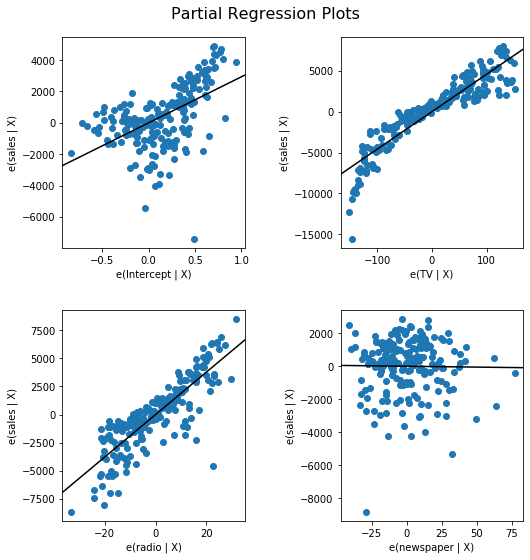

In [7]:
# plot partials
fig = sm.graphics.plot_partregress_grid(ols_model)

# plot formatting
fig.suptitle(t = 'Partial Regression Plots', fontsize = 16, y = 1)
fig.set_size_inches(8, 8)
fig.tight_layout(pad=3.0)

# print partial slopes
print('Partial Regression Coefficients')
print('-------------------------------')
print(round(ols_model.params, 2).to_string())

## Recommendation

Based on our findings above, we recommend the following for our next product campaign:

- Increasing radio advertising which appears to have the greatest ROI and not yet reached its saturation limit.
- Stopping (or greatly cutting back on) newspaper advertising which does not appear to have an effect on product sales.
- Keeping the course on TV ads, which are effective, but appear to be nearing audience saturation.

Depending on marketing budget for future campaigns, this may mean reallocating ad spend away from both newspaper **and** TV toward radio, to maximize incremental ROAS across channels.

It's also important to keep in mind that this was a single campaign for a single product.  Future campaigns, which may be for different products, to different audiences, at different points in time may not need see the same return by ad channel.

It will continue to be important to combine learnings from *all* relevant prior campaigns to inform ad spend in future campaigns.

---
---
---
---

---
---
---
---

## Appendix

### Common pitfalls

Failing to look at ad spend across channels and instead evaluating each channel independently can lead to erroneous results.  To illustrate this, we will examine our data again, but this time analyze each ad spend channel in isolation.

We'll start by defining a function to easily make our comparisons.  We'll fit each model, make predictions, and then plot the relationship.

In [8]:
def lm_fit_plot(df, x, y):
    
    # fit model
    formula = y + ' ~ ' + x
    model = smf.ols(formula = formula, data = df)
    model = model.fit()
    
    # make predictions
    predictions = model.predict(df[x])
    
    # plot actuals and predictions
    sns.scatterplot(df[x], df[y])
    sns.lineplot(df[x], predictions, color = 'red')
    
    # print intercept & slope
    print(round(model.params, 2).to_string())

#### TV ad spend

In isolation, TV ad spend looks like a good advertising channel, estimated to generate \\$45 in product sales per dollar of ad spend.  This is relatively similar to our initial estimate above (from multi-linear regression).

Intercept    7032.59
TV             47.54


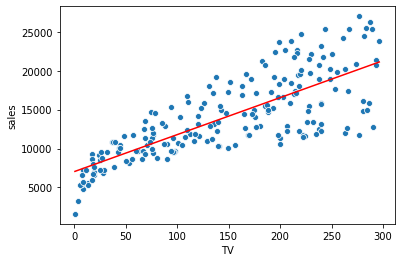

In [9]:
lm_fit_plot(ads, 'TV', 'sales')

#### Radio ad spend

In isolation, radio ad spend looks like a *very* good advertising channel, estimated to generate \\$200 in product sales per dollar of ad spend.  This is also relatively similar to our initial estimate above (from multi-linear regression).

Intercept    9311.64
radio         202.50


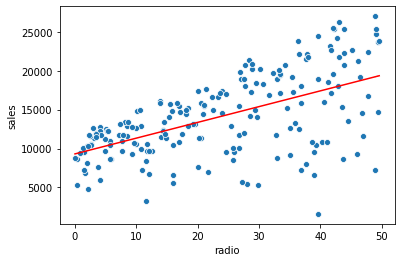

In [10]:
lm_fit_plot(ads, 'radio', 'sales')

#### Newspaper ad spend

Newspaper ad spend, though, when attributed in isolation looks just as valuable as TV ad spend (\\$55 in sales per dollar advertised).

However, we know from our original model that this isn't accurate.  This is due to *spurious correlation*, where newspaper ads are correlated both with product sales **and** our other ad spend channels.

The other ad spend channels are driving the incremental sales. However, since newspaper ads are *also* being ran at the same time in the same markets, it *appears* as though they are driving incremental sales when not controlled for.

Intercept    12351.41
newspaper       54.69


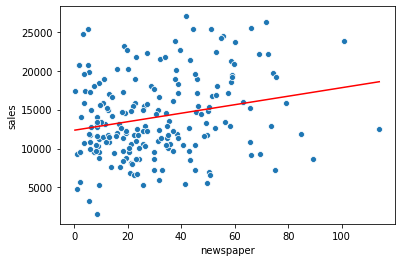

In [11]:
lm_fit_plot(ads, 'newspaper', 'sales')